# QHack 2022 Open Hackathon Project: Matrix-Model Simulations using VQE
Team Name: anonymousr007<br>
Team Member: [Rishabh Singh](https://github.com/anonymousr007)


# Introduction

Matrix quantum mechanics plays various important roles in theoretical physics, such as a holographic description of quantum black holes.Understanding quantum black holes and the role of entanglement in a holographic setup is of paramount importance for the development of better quantum algorithms (quantum error correction codes) and for the realization of a quantum theory of gravity. Quantum computing offer us potentially useful approaches to study the dynamics of matrix quantum mechanics. Gauge/gravity duality translates difficult (or intractable) problems in quantum gravity to well-defined problems in non-gravitational quantum theories. Although it originated from string/M-theory, connections to various other fields including quantum information theory, condensed matter theory, and cosmology, have been recognized by now with research programs actively pursued. Quantum mechanics with matrix degrees of freedom (matrix QM, or matrix models in the following) play important roles in gauge/gravity duality. More specifically, Yang–Mills-type matrix models can provide us with a nonperturbative formulation of superstring/M-theory. In certain regions of the parameter space (i.e., strong coupling and large-N), weakly-coupled gravity with small stringy corrections can be described by matrix models.Therefore, matrix models can offer us an ideal setup to study quantum corrections to gravity. By solving the matrix models, it should be possible to study fascinating problems such as the microscopic mechanism of black hole evaporation.

## Quantum Computer 

- On a quantum computer, quantum states are directly realized.
- Quantum Computing does not suffer from the sign problem
- The Hamiltonian time evolution can be simulated straightforwardly.
- Some research directions that could benefit from direct quantum simulations are the formation and evaporation of a black hole, or a wormhole, and quantum teleportation.
- The biggest challenge is that we do not yet have a reliable large-scale quantum computer.
- Although we can emulate a quantum computer on a classical computer, these simulations are restricted to systems with only a small number of qubits.
- Furthermore, the effects of the regularization needed to map a theory on a quantum device are not well understood yet.

## Variational Quantum Eigensolver (VQE)

- The Variational Quantum Eigensolver (VQE) is expected to be a useful quantum-classical hybrid algorithm in the Noisy Intermediate Scale Quantum (NISQ) era.
- Being a variational method, the VQE can have systematic errors: a priori, we do not know if we can get the right answer, because the simulation might be
trapped in a local optimum.
- This is a general problem for variational methods.
- Quantum computing represents the computation in terms of qubits and quantum gates which can represent larger Hamiltonians and Hilbert spaces on quantum hardware than classical computers that are limited by memory constraints.
- Also, quantum computing represents fermions straightforwardly in a similar way to how they represent bosons and, as mentioned above, are not susceptible to the sign problem like classical methods using Monte Carlo algorithms.
- Some of the disadvantages of NISQ devices include the lack of quantum error correction for quantum gates and the presence of noise which can lead to inaccurate quantum gates and decoherence of the qubits during the computation.
- For hybrid quantum-classical computations that we discuss here, the advantages are that many parts of a hybrid quantum-classical variational calculation, such as optimization, can be done efficiently on a classical computer, while expectation values can be computed on a quantum computer.
- This leads to a lower depth for the circuits, making them less susceptible to decoherence.
- However, these methods include complicated state-preparation protocols and variational ansatze for the wave function that need to be specified
to have strong overlaps with the true ground state. Such wave functions may need a high-depth quantum circuit which is difficult to implement on a NISQ hardware, and it is prone to decoherence.

# Abstract

This project aims to use a truncated (regularized) Hamiltonian for the matrix quantum mechanics models. This Hamiltonian is constructed by considering a truncated Hilbert space in the Fock basis. The truncated Hilbert space is constructed starting from the individual matrix degrees of freedom.

Two types of matrix quantum mechanics models are used

- A Yang-Mills-type bosonic 2-matrix model with SU(2) gauge group, which has 6 bosonic degrees of freedom in total.
- A Supersymmetric 2-matrix model with SU(2) gauge group which corresponds to with the minimal number of degrees of freedom 6 bosons and 3 fermions.

Quantum mechanics with matrix degrees of freedom plays an important role in gauge-gravity duality. Gauge-gravity duality translates difficult problems in quantum gravity to well-defined problems in non-gravitational quantum theories. Although it originated from string–M-theory, connections to various other fields, including 

- Quantum Information Theory
- Condensed Matter Theory
- Cosmology
- Holographic simulation of Quantum Black Holes
- Complex high-dimensional supergravity theories

We use the **Variational Quantum EigenSolver (VQE)** to estimate the low-energy spectrum As for the VQE, the specific architecture that we use does not show a satisfactory performance at strong coupling, perhaps due to the variational forms parametrized by the quantum circuits not adequately probing the full gauge-invariant Hilbert space. This result shows that going beyond the VQE and using more complicated or fully quantum algorithms is not the correct way to approach matrix quantum mechanics for now, because they would require even deeper quantum circuits that are more prone to noise on actual quantum hardware.

In [1]:
#@title Check the box below if you have a GPU

HAS_GPU = True #@param {type: "boolean"}
if HAS_GPU:
  print("Installing qiskit with GPU support")
  !pip3 -q install qiskit[visualization] qiskit-aer-gpu pylatexenc
else:
  print("Installing qiskit")
  !pip3 -q install qiskit[visualization] pylatexenc

Installing qiskit with GPU support


In [2]:
!pip install qiskit

# Libraries

In [3]:
# Let us begin by importing necessary libraries.
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# qiskit
from qiskit import Aer
from qiskit.algorithms import VQE, NumPyEigensolver
from qiskit.algorithms.optimizers import SLSQP, SPSA
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import MatrixOp
from qiskit.utils import algorithm_globals, QuantumInstance

# scipy
from scipy.sparse import diags, identity, kron
from scipy.sparse.linalg import eigsh

# Basis operators for a single boson

We define the annihilation operator in a $N \times N$ representation for each bosonic matrix, and we define the identity operator.
Combining them for all bosonic matrices will allow us to construct the Hamiltonian.

In [4]:
n = 2  # cutoff for Fock space. The number of qubits used will be K = log2(N) 
annihilation_operator = np.array(np.diagflat(np.sqrt(np.linspace(1,n-1,n-1)),k=1))
identity = np.identity(n)

In [5]:
print(annihilation_operator)

[[0. 1.]
 [0. 0.]]


In [6]:
print(identity)

[[1. 0.]
 [0. 1.]]


In [7]:
bosonic_dof = 6  # number of bosonic dof as matrices: SU(2) -> 2^2-1=6 generators
bosonList = [annihilation_operator]
for bosons in range(0, bosonic_dof-1):
  bosonList.append(identity)
with np.printoptions(precision=3, suppress=True, linewidth=120, threshold=sys.maxsize):
  for i in bosonList:
    print(f"{i}\n")

[[0. 1.]
 [0. 0.]]

[[1. 0.]
 [0. 1.]]

[[1. 0.]
 [0. 1.]]

[[1. 0.]
 [0. 1.]]

[[1. 0.]
 [0. 1.]]

[[1. 0.]
 [0. 1.]]



In [8]:
# This for loop takes the appropriate Kronecker products for each boson.
for i in range(0, bosonic_dof):
  for j in range(0, bosonic_dof - 1):
    # For the nth boson, the nth Kronecker product is with the annihilation operator.
    if j == i-1 and i != 0:
        bosonList[i] = np.kron(bosonList[i], annihilation_operator)
    # Else, the nth Kronecker product is with the identity matrix.
    else:
        bosonList[i] = np.kron(bosonList[i], identity) 

In [9]:
[x.shape for x in bosonList]

[(64, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]

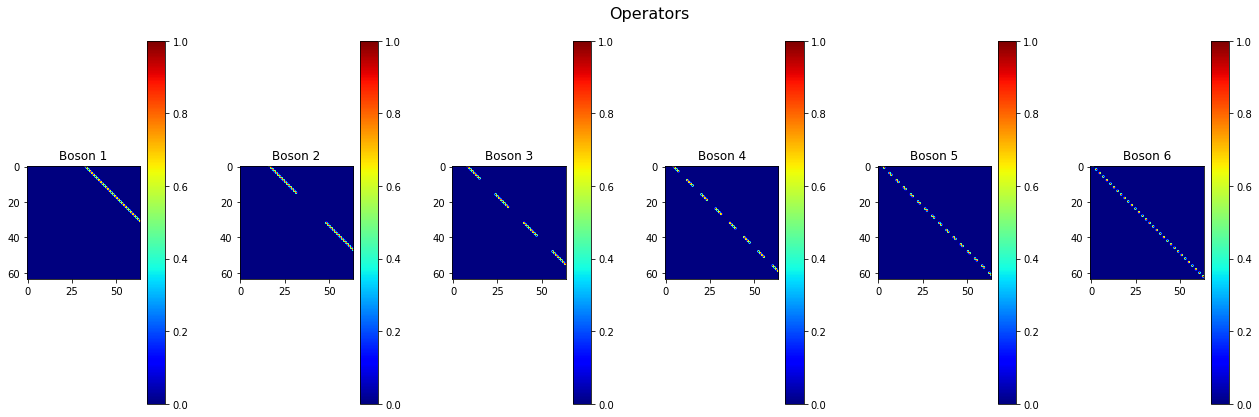

In [10]:
fig, ax = plt.subplots(ncols=6, figsize=(18, 6))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.5, hspace=1)
for i,axi in enumerate(np.ravel(ax)):
  pos = axi.imshow(bosonList[i], cmap='jet')
  fig.colorbar(pos, ax=axi)
  axi.set_title(f"Boson {i+1}")
fig.suptitle('Operators', fontsize=16)
fig.subplots_adjust(top=0.9)

# Creating the Bosons and the Quartic Hamiltonians

The following cell defines a function which creates the bosons, then it creates the simple quartic and full quartic SU2 Hamiltonians. The function recieves the number of bosons and the size of the bosons as arguments. For example, for 6 bosons that are 8x8, the function call would look like bosonHamiltonians(6, 8). The function returns the two Hamiltonians.

First, an annihilation operator and identity matrix is created. Each of the 6 bosons is constructed by taking the Kronecker product of the annihilation operator with the identity matrix, in a specific order. For the $n^{th}$ boson, the annhiliation operator will be in the $n^{th}$ position of the Kronecker product. For example, the first boson's Kronecker product would look like $$\hat{a} \otimes I \otimes I \otimes I \otimes I \otimes I$$ where $\hat{a}$ is the annihilation operator and $I$ is the identity matrix. The 2nd boson would look like $$I \otimes \hat{a} \otimes I \otimes I \otimes I \otimes I$$ and so on.

In [12]:
def bosonHamiltonians(num_boson, bosonMatrixDim, coupling=0.1):
    # This function takes the number of bosons (num_boson) and the size of the bosons (bosonMatrixDim)
    # as arguments. If the size of the boson is 2 x 2, for example, then bosonMatrixDim = 2.
    # coupling is lambda/2 and lambda is the 'tHooft coupling'
    
    # Create the n x n annhiliation operator. Here, we create a list with all the integers from
    # the square root of 1 to the square root of n-1, where n x n is the size of the boson.
    # This list is injected as the upper diagonal in an array of zeros.
    ann_op = np.array(np.diagflat(np.sqrt(np.linspace(1,bosonMatrixDim-1,bosonMatrixDim-1)),k=1))
    
    # Create the n x n identity matrix.
    id = np.identity(bosonMatrixDim)
    
    # Create a list which holds the six bosons. bosonList[0] is the first boson. bosonList[5] is the 6th boson.
    # For the first boson, the Kronecker product starts with the annihilation operator.
    bosonList = [ann_op]
    
    # This for loop creates the list of bosons before the Kronecker products are taken. The first one was 
    # already created in the previous line.
    for bosons in range(0,num_boson-1):
        bosonList.append(id)
    
    # This for loop takes the appropriate Kronecker products for each boson.
    for i in range(0,num_boson):
        for j in range(0,num_boson-1):
            
            # For the nth boson, the nth Kronecker product is with the annihilation operator.
            if j == i-1 and i != 0:
                bosonList[i] = np.kron(bosonList[i], ann_op)
            # Else, the nth Kronecker product is with the identity matrix.
            else:
                bosonList[i] = np.kron(bosonList[i], id)

    # Create the position operators. Normalized as in the notes
    x = []
    for r in range(0, num_boson):
        x.append((1/np.sqrt(2))*(bosonList[r] + np.transpose(np.conjugate(bosonList[r]))))
    
    # Create the simple quadratic Hamiltonian.
    H2MM = 0

    for i in range(0,num_boson):
        # The @ symbol is a shorthand for matrix multiplication. It's equivalent to using np.matmul().
        H2MM = H2MM + (np.transpose(np.conjugate(bosonList[i])) @ bosonList[i])

    H2MM = H2MM + 0.5*num_boson*np.identity(bosonMatrixDim**(num_boson))

    # Create the full quartic SU(2) Hamiltonian.
    x_sq = []

    for i in x:
        x_sq.append(i @ i)

    H4MM1 = (H2MM + coupling*((x_sq[2] @ x_sq[3]) 
                              + (x_sq[2] @ x_sq[4]) 
                              + (x_sq[1] @ x_sq[3]) 
                              + (x_sq[1] @ x_sq[5])
                              + (x_sq[0] @ x_sq[4])
                              + (x_sq[0] @ x_sq[5])
                              - 2*((x[0] @ x[2]) @ (x[3] @ x[5]))
                              - 2*((x[0] @ x[1]) @ (x[3] @ x[4]))
                              - 2*((x[1] @ x[2]) @ (x[4] @ x[5]))))
    return H2MM, H4MM1

# Set the number of bosons here. For the proper full quartic SU(2) Hamiltonian, this has to be 6.
num_boson = 6

# Set the size of the bosons here. For an n x n boson, bosonMatrixDim = n.
# 5 crashes this colab with 12Gb of RAM ->  tries 6 of these tcmalloc: large alloc 1953128448 bytes 
bosonMatrixDim = 2

# the function actually creates intermediate matrices x and x2 so the memory footprint is even higher...for N=5 it requires ~50GB of RAM
H2MM, H4MM1 = bosonHamiltonians(num_boson, bosonMatrixDim, coupling=0.1)  # we can change the coupling by adding coupling=0.5 to the args

# Set the Hamiltonian that you want to run the VQE algorithm with here.
hamiltonian = H4MM1

# Use numpy to find the eigenvalues of the simple quartic Hamiltonian
# this can take a long time for large matrices
val,vec=np.linalg.eig(hamiltonian)
z = np.argsort(val)
z = z[0:len(hamiltonian)]
energies=(val[z])

if hamiltonian.all() == H4MM1.all():
    # Sometimes there are negligible imaginary parts (e.g. order of 10^-16), so I take the real parts only.
    print('Full Quartic SU2 Eigenvalues:\n\n', np.real(energies))
else:
    print('Simple Quartic Eigenvalues:\n\n', energies)

Full Quartic SU2 Eigenvalues:

 [3.14807787 4.14674965 4.14674965 4.14674965 4.14674965 4.14674965
 4.14674965 5.04817155 5.09501244 5.09501244 5.09501244 5.09501244
 5.09501244 5.09501244 5.2        5.2        5.2        5.2
 5.2        5.2        5.2        5.2        6.         6.
 6.10024938 6.10024938 6.10024938 6.10024938 6.10024938 6.10024938
 6.2        6.2        6.2        6.2        6.2        6.2
 6.2        6.2        6.2        6.2        6.2        6.2
 7.05192213 7.10498756 7.10498756 7.10498756 7.10498756 7.10498756
 7.10498756 7.2        7.2        7.2        7.2        7.2
 7.2        7.2        7.2        8.15300098 8.15300098 8.15300098
 8.15300098 8.15300098 8.15300098 9.15182845]


# Convert the Hamiltonian
Now, we take the Hamiltonian matrix and map it onto a qubit operator. There may be better ways to do this now that `qiskit` has added new ways to map Hamiltonians to qubit operators.

In fact, we should skip the creation of the Hamiltonian as a matrix and directly used operators in `qiskit`

In [13]:
start_time = time.time()
warnings.filterwarnings("ignore")

qubit_operator = MatrixOp(primitive=hamiltonian)
print("Size of Hamiltonian:", np.shape(hamiltonian))

end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (64, 64)
Program runtime:  0.0030336380004882812


In [14]:
print(qubit_operator)

Operator([[3.15+0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
           0.  +0.j],
          [0.  +0.j, 4.15+0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
           0.  +0.j],
          [0.  +0.j, 0.  +0.j, 4.15+0.j, ..., 0.  +0.j, 0.  +0.j,
           0.  +0.j],
          ...,
          [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 8.15+0.j, 0.  +0.j,
           0.  +0.j],
          [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 8.15+0.j,
           0.  +0.j],
          [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
           9.15+0.j]],
         input_dims=(2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2))


In [15]:
print("Total number of qubits: ",qubit_operator.num_qubits)
print("Type of qubitOp: ",type(qubit_operator).__name__)

Total number of qubits:  6
Type of qubitOp:  MatrixOp


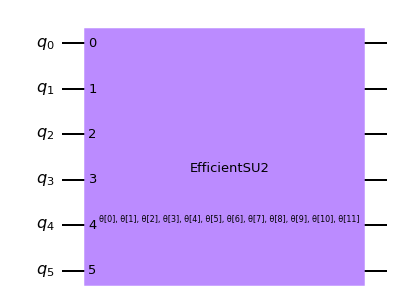

In [19]:
ansatz = EfficientSU2(qubit_operator.num_qubits, su2_gates=['ry'], entanglement="full", reps=1)
ansatz.draw(output='mpl')

In [20]:
np.log2(hamiltonian.shape[0])

6.0

# Looping the VQE algorithm over several optimizers

## Statevector simulator

In [21]:
warnings.filterwarnings("ignore")
seed = 0
algorithm_globals.random_seed = seed
if HAS_GPU:
  backend = Aer.get_backend("statevector_simulator", method="statevector_gpu")
else:
  backend = Aer.get_backend("statevector_simulator", max_parallel_threads=6, max_parallel_experiments=0)
quantum_instance = QuantumInstance(backend, seed_transpiler = seed, seed_simulator = seed)

In [22]:
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

optimizer = SLSQP(maxiter=1000)

vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(qubit_operator)
vqe_result = np.real(result.eigenvalue)
print(f"VQE gs energy: {vqe_result}")

VQE gs energy: 3.150000100711781


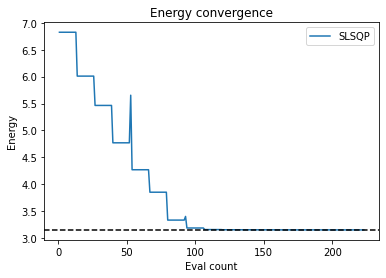

In [23]:
# Plot all of the optimizers in a single convergence plot. If you see that the optimizer isn't converging,
# increase the maximum iterations or maximum function evaluations in the optimizer list above.

labelList = ["SLSQP"]

plt.plot(counts, values)
plt.axhline(y=np.real(energies[0]),xmin=0,xmax=counts[-1],color='k',linestyle='--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence')
plt.legend(loc='upper right', labels=labelList)

## QASM Simulator

In [24]:
warnings.filterwarnings("ignore")

backendQasm = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backendQasm, shots=1024)
optimizer = SPSA(maxiter=10000)

counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)

result = vqe.compute_minimum_eigenvalue(qubit_operator)
vqe_result = np.real(result.eigenvalue)
print(f"VQE gs energy (QASM): {vqe_result}")

VQE gs energy (QASM): 3.15


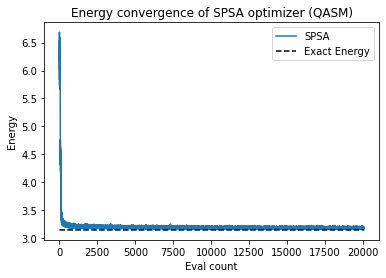

In [25]:
# Plot convergence plot for the SPSA optimizer
plt.plot(counts, values, label="SPSA")
plt.plot(counts,[np.real(energies[0])]*len(counts), 'k--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence of SPSA optimizer (QASM)')
plt.legend(loc='upper right')

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table